In [22]:
import os
import numpy as np
import pydicom
import highdicom as hd
from glob import glob
import matplotlib
# matplotlib.use('Agg')  # Força un backend no interactiu per a figures fora de pantalla
import matplotlib.pyplot as plt
from highdicom.seg import Segmentation
import imageio
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from skimage import measure
from PIL import Image
import io
from scipy import ndimage
from scipy.ndimage import center_of_mass
from skimage.segmentation import flood
from skimage import exposure

In [3]:
# Carregam tots els arxius DICOM
reference_image_files = glob(os.path.join('0745/10_AP_Ax5.00mm', '*.dcm'))

ct_images = []
for file in reference_image_files:
    ds = pydicom.dcmread(file, stop_before_pixels=True)
    ct_images.append(ds)

In [4]:
print(ct_images[0])

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 180
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.5.3581191.17199.1439447153.358
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'REFORMATTED', 'AVERAGE']
(0008,0012) Instance Creation Date              DA: ''
(0008,0013) Instance Creation Time              TM: '111510'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0017) Acquisition UID              

In [5]:
example_ct = ct_images[0]
print("  - AcquisitionNumber:", example_ct.AcquisitionNumber)
print("  - InstanceNumber:", example_ct.InstanceNumber)
print("  - ImagePositionPatient:", example_ct.ImagePositionPatient)

  - AcquisitionNumber: 1
  - InstanceNumber: 48
  - ImagePositionPatient: [-199.944138, -201.066803, -176.000000]


In [6]:
seg_liver = pydicom.dcmread("0745/10_AP_Ax5.00mm_ManualROI_Liver.dcm")
# print(seg_liver.segment_descriptions)  # Llista d’objectes SegmentDescription
print(seg_liver.pixel_array.shape)  # (4, slices, height, width)

(24, 512, 512)


In [ ]:
# 1. Carrega el fitxer DICOM amb PyDicom
seg_ds = pydicom.dcmread("0745/10_AP_Ax5.00mm_ManualROI_Liver.dcm")

# 2. Llegeix-lo com a segmentació DICOM amb HighDicom
seg = Segmentation.from_dataset(seg_ds)
print(seg)



# 3. Mostra les descripcions dels segments
print(f"✅ Nombre de segments trobats: {len(seg.segment_descriptions)}")
for i, desc in enumerate(seg.segment_descriptions, 1):
    print(f"Segment {i}:")
    print(f"  - Label: {desc.segment_label}")
    print(f"  - Category: {desc.segment_category_code_value}")
    print(f"  - Algorithm type: {desc.segment_algorithm_type}")

In [7]:
ct_folder = '0745/10_AP_Ax5.00mm'
# 1. Carregam tots els CT slices
ct_files = glob(os.path.join(ct_folder, '*.dcm'))

# Llegim i guardam informació important
ct_slices = []
ct_positions = []

for file in ct_files:
    ds = pydicom.dcmread(file)
    ct_slices.append(ds)
    ct_positions.append(ds.ImagePositionPatient[2])  # Eix Z

# Ordenam els slices pel valor Z
sorted_idx = np.argsort(ct_positions)
ct_slices = [ct_slices[i] for i in sorted_idx]
# Stackam el volum 3D
ct_volume = np.stack([s.pixel_array for s in ct_slices], axis=0)
print(f'CT volume shape: {ct_volume.shape}')

CT volume shape: (52, 512, 512)


In [8]:
seg_file = "0745/10_AP_Ax5.00mm_ManualROI_Tumor.dcm"
# 2. Carregam la segmentació SEG
seg_dataset = pydicom.dcmread(seg_file)

# Important: comprovam que és de tipus SEG
assert seg_dataset.Modality == 'SEG'

# 3. Accedir a les màscares i la informació de cada "frame"
# El SEG pot tenir múltiples "frames", un per slice
n_frames = seg_dataset.NumberOfFrames
print(f"Nombre de frames: {n_frames}")

Nombre de frames: 12


In [9]:
# print(len(seg_dataset.PerFrameFunctionalGroupsSequence))
segmentation_masks = []
for i in range(n_frames):
    frame = seg_dataset.PerFrameFunctionalGroupsSequence[i]
    # print(frame)
    # Trobar la posició espacial
    image_position = frame.PlanePositionSequence[0].ImagePositionPatient
    # Saber quin segment és
    segment_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
    # referenced_frame = frame.ReferencedImageSequence[0].ReferencedFrameNumber
    info = frame.DerivationImageSequence[0].SourceImageSequence[0]

    referenced_frame = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedFrameNumber
    # ReferencedFrameNumber
    # Pixel array: recorda que està en seqüència
    mask = seg_dataset.pixel_array[i]
    segmentation_masks.append({
        'position': image_position,
        'segment_number': segment_number,
        'mask': mask,
        'referenced_frame': referenced_frame
    })

In [12]:
segmentation_masks_sorted = sorted(segmentation_masks, key=lambda x: x['position'][2])
tumor_mask_volume = np.stack([frame['mask'] for frame in segmentation_masks_sorted if frame['segment_number'] == 1])

print(f'Tumor mask volume shape: {tumor_mask_volume.shape}')

Tumor mask volume shape: (12, 512, 512)


In [31]:
# Fes una llista de les posicions Z de la CT
ct_positions = [s.ImagePositionPatient[2] for s in ct_slices]

# Ara llistam les posicions Z de cada màscara del tumor
tumor_positions = [frame['position'][2] for frame in segmentation_masks_sorted if frame['segment_number'] == 1]

# Associam la màscara de tumor amb l'índex de la CT
tumor_mask_full = np.zeros_like(ct_volume, dtype=np.uint8)

for mask, pos in zip(tumor_mask_volume, tumor_positions):
    # Cerca l'índex del CT slice que correspon a aquesta posició
    idx = np.argmin(np.abs(np.array(ct_positions) - pos))
    
    # Posam la màscara en el volum complet
    tumor_mask_full[idx] = mask

In [ ]:
print(f'Tumor mask volume shape: {tumor_mask_full.shape}')

Tumor mask volume shape: (52, 512, 512)


In [23]:
# Normalitza el CT per visualitzar
ct_norm = (ct_volume - np.min(ct_volume)) / (np.max(ct_volume) - np.min(ct_volume))

In [34]:
def compute_mip(volume, axis):
    return np.max(volume, axis=axis)

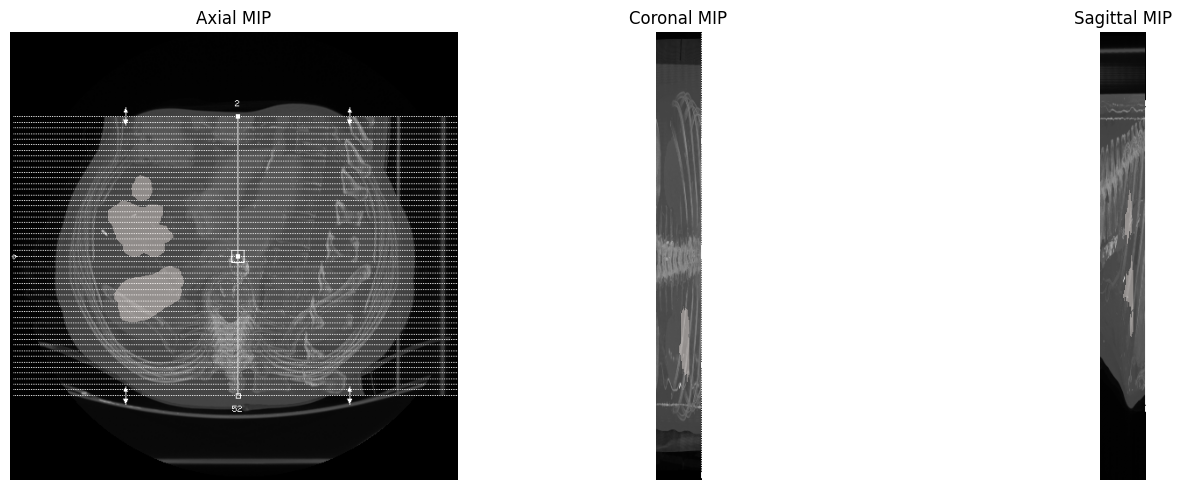

In [42]:
mip_ct_axial     = np.max(ct_norm, axis=0)
mip_ct_coronal   = np.max(ct_norm, axis=1)
mip_ct_sagittal  = np.max(ct_norm, axis=2)

mip_mask_axial   = np.max(tumor_mask_full, axis=0)
mip_mask_coronal = np.max(tumor_mask_full, axis=1)
mip_mask_sagittal= np.max(tumor_mask_full, axis=2)

# Visualització amb superposició
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(mip_ct_axial, cmap='gray')
axes[0].imshow(np.ma.masked_where(mip_mask_axial == 0, mip_mask_axial), cmap='Reds', alpha=0.4)
axes[0].set_title("Axial MIP")
axes[0].axis('off')

axes[1].imshow(np.rot90(mip_ct_coronal), cmap='gray')
axes[1].imshow(np.ma.masked_where(np.rot90(mip_mask_coronal) == 0, np.rot90(mip_mask_coronal)), cmap='Reds', alpha=0.4)
axes[1].set_title("Coronal MIP")
axes[1].axis('off')

axes[2].imshow(np.rot90(mip_ct_sagittal), cmap='gray')
axes[2].imshow(np.ma.masked_where(np.rot90(mip_mask_sagittal) == 0, np.rot90(mip_mask_sagittal)), cmap='Reds', alpha=0.4)
axes[2].set_title("Sagittal MIP")
axes[2].axis('off')


plt.tight_layout()
plt.show()

## MAKE A GIF

In [ ]:
frames = []
angles = np.linspace(0, 360, 36, endpoint=False)

for angle in angles:
    fig, ax = plt.subplots(figsize=(5, 5))

    # Rotate the volume around the axial axis (z-axis)
    rotated_ct = ndimage.rotate(ct_norm, angle, axes=(1, 2), reshape=False, order=1)
    rotated_mask = ndimage.rotate(tumor_mask_full, angle, axes=(1, 2), reshape=False, order=0)

    # Take sagittal MIP (Z-Y)
    mip_ct = np.max(rotated_ct, axis=2)      # shape: (Z, Y)
    mip_mask = np.max(rotated_mask, axis=2)

    # Rotate image for better orientation (optional)
    # mip_ct_rot = np.rot90(mip_ct)
    # mip_mask_rot = np.rot90(mip_mask)
    mip_ct_rot = mip_ct
    mip_mask_rot = mip_mask

    # Show CT image with mask overlay using correct aspect ratio
    ax.imshow(mip_ct_rot, cmap='viridis', aspect=4)
    ax.imshow(np.ma.masked_where(mip_mask_rot == 0, mip_mask_rot), cmap='Reds', alpha=0.4, aspect=4)
    ax.axis('off')

    # Save frame as PNG in memory
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frame = Image.open(buf)
    frames.append(frame.copy())
    plt.close(fig)

# Save all frames to a GIF
frames[0].save("mip_rotation.gif", save_all=True, append_images=frames[1:], duration=100, loop=0)

In [ ]:
# Suposem que la màscara binària és: tumor_mask_full.shape = (z, y, x)
mask = tumor_mask_full > 0  # asseguram que és binària

# Bounding box: coordenades min i max de cada eix
z_indices, y_indices, x_indices = np.where(mask)

z_min, z_max = z_indices.min(), z_indices.max()
y_min, y_max = y_indices.min(), y_indices.max()
x_min, x_max = x_indices.min(), x_indices.max()

bounding_box = {
    'z': (z_min, z_max),
    'y': (y_min, y_max),
    'x': (x_min, x_max)
}

print("Bounding box:", bounding_box)

# Centroid (centre de massa)
centroid_z, centroid_y, centroid_x = center_of_mass(mask)
centroid = (centroid_z, centroid_y, centroid_x)

print("Centroid:", centroid)

Bounding box: {'z': (np.int64(26), np.int64(37)), 'y': (np.int64(163), np.int64(331)), 'x': (np.int64(112), np.int64(198))}
Centroid: (np.float64(32.7356521159169), np.float64(256.62136926001267), np.float64(152.91366258712108))


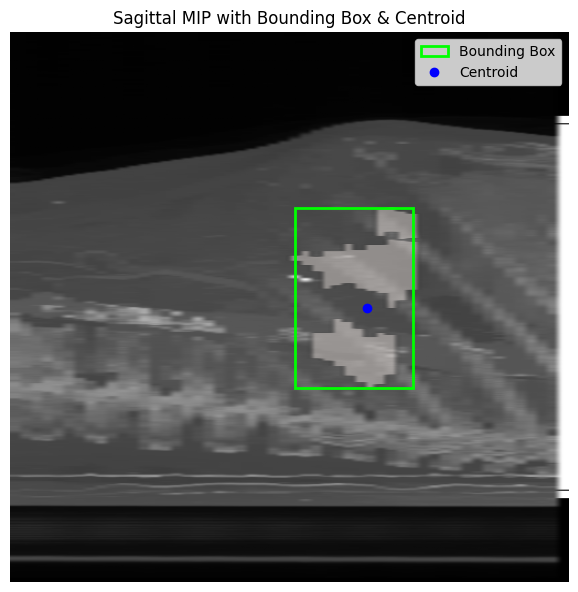

In [21]:
mip_sagittal = np.max(ct_volume, axis=2)
mask_mip_sagittal = np.max(tumor_mask_full, axis=2)

# Coordenades projectades (eix Z vs Y)
cz, cy, cx = centroid
zmin, zmax = bounding_box['z']
ymin, ymax = bounding_box['y']

# Imatge
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mip_sagittal.T, cmap='gray', origin='lower',aspect=0.1)  # .T per Z vs Y

# Sobreposa la màscara
ax.imshow(np.ma.masked_where(mask_mip_sagittal.T == 0, mask_mip_sagittal.T), cmap='Reds', alpha=0.4,aspect=0.1)

# Dibuixa la bounding box (projectada sobre Z vs Y)
rect = plt.Rectangle((zmin, ymin), zmax - zmin, ymax - ymin,
                     linewidth=2, edgecolor='lime', facecolor='none', label='Bounding Box')
ax.add_patch(rect)

# Marca el centroid
ax.plot(cz, cy, 'bo', markersize=6, label='Centroid')

ax.set_title('Sagittal MIP with Bounding Box & Centroid')
ax.legend(loc='upper right')
ax.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# 1. Imatge CT normalitzada (ja l’has de tenir)
ct_volume = ct_norm  # shape: (z, y, x)

# 2. Usa el centroid (com a voxel de partida)
seed_z, seed_y, seed_x = map(int, centroid)

# 3. Limita el CT a la bounding box
z_min, z_max = bounding_box['z']
y_min, y_max = bounding_box['y']
x_min, x_max = bounding_box['x']

ct_crop = ct_volume[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]
seed_local = (seed_z - z_min, seed_y - y_min, seed_x - x_min)

# 4. Defineix tolerància HU per a region growing (ajustar si cal)
tolerance = 30  # ± HU respecte el valor inicial
seed_value = ct_crop[seed_local]
lower = seed_value - tolerance
upper = seed_value + tolerance

# 5. Aplica region growing
mask_seg = flood(ct_crop, seed_point=seed_local, tolerance=tolerance)

# 6. Reconstrueix la màscara segmentada a escala global
segmentation = np.zeros_like(ct_volume, dtype=bool)
segmentation[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1] = mask_seg

print("Segmentació semi-automàtica feta.")

Segmentació semi-automàtica feta.


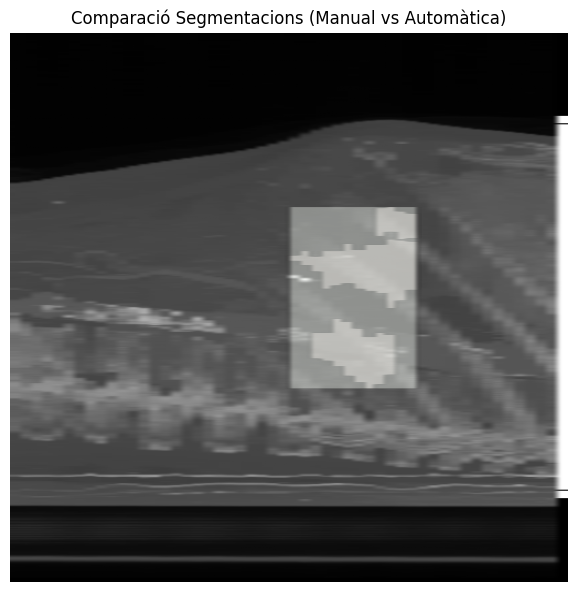

In [26]:
# Crea MIP per eix sagital (projecció en X)
mip_ct = np.max(ct_volume, axis=2)
mip_manual = np.max(tumor_mask_full, axis=2)
mip_auto = np.max(segmentation, axis=2)

# Visualització
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mip_ct.T, cmap='gray', origin='lower')  # MIP transposada

# Màscara manual en vermell
ax.imshow(np.ma.masked_where(mip_manual.T == 0, mip_manual.T), cmap='Reds', alpha=0.4, label='Manual', aspect=0.1)

# Màscara automàtica en verd
ax.imshow(np.ma.masked_where(mip_auto.T == 0, mip_auto.T), cmap='Greens', alpha=0.4, label='Automàtica',aspect=0.1)

ax.set_title('Comparació Segmentacions (Manual vs Automàtica)')
ax.axis('off')
plt.tight_layout()
plt.show()

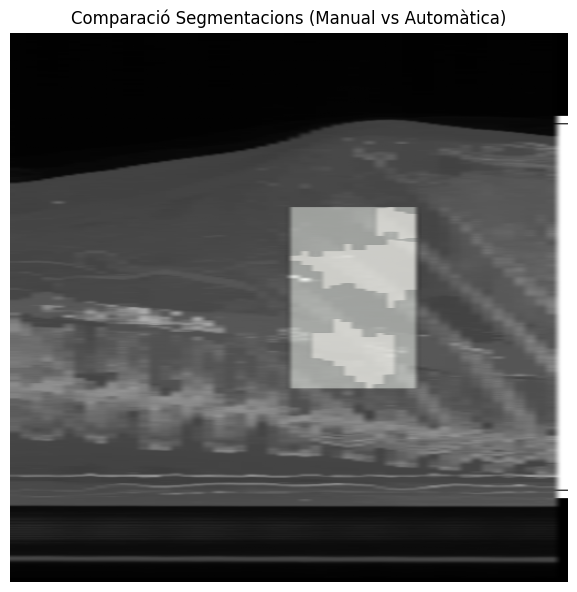

In [28]:
# Assegura't que les màscares siguin binàries
mip_manual_bin = (mip_manual > 0).astype(np.uint8)
mip_auto_bin = (mip_auto > 0).astype(np.uint8)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mip_ct.T, cmap='gray', origin='lower')

# Màscara manual (vermella)
ax.imshow(np.ma.masked_where(mip_manual_bin.T == 0, mip_manual_bin.T),
          cmap='Reds', alpha=0.5,aspect=0.1)

# Màscara automàtica (verd)
ax.imshow(np.ma.masked_where(mip_auto_bin.T == 0, mip_auto_bin.T),
          cmap='Greens', alpha=0.5,aspect=0.1)

ax.set_title('Comparació Segmentacions (Manual vs Automàtica)')
ax.axis('off')
plt.tight_layout()
plt.show()

In [30]:
# Normalitzar les màscares (per si tenen valors >1 o flotants)
mip_manual_bin = (mip_manual > 0).astype(np.uint8)
mip_auto_bin = (mip_auto > 0).astype(np.uint8)

# Crear una imatge RGB a partir del MIP en escala de grisos
mip_rgb = np.stack([mip_ct]*3, axis=-1)
mip_rgb = (255 * (mip_rgb - mip_rgb.min()) / (np.ptp(mip_rgb) + 1e-8)).astype(np.uint8)

# Crear còpia per superposar màscares
overlay = mip_rgb.copy()

# Màscara manual (vermella)
overlay[mip_manual_bin.T == 1] = [255, 0, 0]

# Màscara automàtica (verda)
# Nota: si hi ha solapament, la màscara automàtica tindrà prioritat
overlay[mip_auto_bin.T == 1] = [0, 255, 0]

plt.figure(figsize=(6, 6))
plt.imshow(overlay, origin='lower')
plt.title("Comparació Segmentacions (Manual vs Automàtica)")
plt.axis('off')
plt.show()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 52 but size of corresponding boolean axis is 512